## 환경 설정 및 라이브러리 임포트

In [1]:
import sys
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle, FancyBboxPatch
import warnings
warnings.filterwarnings('ignore')
# Set Korean font
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# Set style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("husl")

### Load data from optimization_comparison_results.xlsx

In [ ]:
'''def load_data_from_excel():
    file_path = '../optimization_comparison_results.xlsx'
    df_raw = pd.read_excel(file_path, sheet_name='Raw Results')
    
    algorithms = ['NSGA-II', 'NSGA-III', 'SPEA2', 'ε-MOEA']
    metrics_data = {
        'HYPERVOLUME': {},
        'SPACING': {},
        'DIVERSITY': {},
        'CONVERGENCE': {},
        'EXECUTION_TIME': {}
    }
    
    # Row ranges for each metric
    row_ranges = {
        'HYPERVOLUME': [1, 2, 3, 4],
        'SPACING': [8, 9, 10, 11],
        'DIVERSITY': [15, 16, 17, 18],
        'CONVERGENCE': [22, 23, 24, 25],
        'EXECUTION_TIME': [29, 30, 31, 32]
    }
    
    for metric, rows in row_ranges.items():
        for idx in rows:
            row = df_raw.iloc[idx]
            algo = str(row['HYPERVOLUME']).strip()
            if algo in algorithms:
                values = []
                for col in df_raw.columns[1:11]:
                    val = row[col]
                    if pd.notna(val):
                        try:
                            values.append(float(val))
                        except:
                            pass
                metrics_data[metric][algo] = values
    
    return algorithms, metrics_data

ALGORITHMS, DATA = load_data_from_excel()'''

In [8]:
import glob

def load_data_from_multiple_files():
    folder_path = '../../result/optimization results'
    
    excel_files = glob.glob(os.path.join(folder_path, '*.xlsx'))
    algorithms = ['NSGA-II', 'NSGA-III', 'SPEA2', 'ε-MOEA']
    
    all_runs_data = []
    
    # Row ranges for each metric
    row_ranges = {
        'HYPERVOLUME': [1, 2, 3, 4],
        'SPACING': [8, 9, 10, 11],
        'DIVERSITY': [15, 16, 17, 18],
        'CONVERGENCE': [22, 23, 24, 25],
        'EXECUTION_TIME': [29, 30, 31, 32]
    }
    
    for file_idx, file_path in enumerate(excel_files, 1):
        try:
            df_raw = pd.read_excel(file_path, sheet_name='Raw Results')
            
            metrics_data = {
                'HYPERVOLUME': {},
                'SPACING': {},
                'DIVERSITY': {},
                'CONVERGENCE': {},
                'EXECUTION_TIME': {}
            }
            
            for metric, rows in row_ranges.items():
                for idx in rows:
                    row = df_raw.iloc[idx]
                    algo = str(row['HYPERVOLUME']).strip()
                    if algo in algorithms:
                        values = []
                        for col in df_raw.columns[1:11]:  # 10개의 실험 결과
                            val = row[col]
                            if pd.notna(val):
                                try:
                                    values.append(float(val))
                                except:
                                    pass
                        metrics_data[metric][algo] = values
            
            all_runs_data.append({
                'file_name': os.path.basename(file_path),
                'file_index': file_idx,
                'data': metrics_data
            })
            
        except Exception as e:
            continue
    
    return algorithms, all_runs_data

ALGORITHMS, DATA = load_data_from_multiple_files()

## Figure 1: Performance Radar Chart

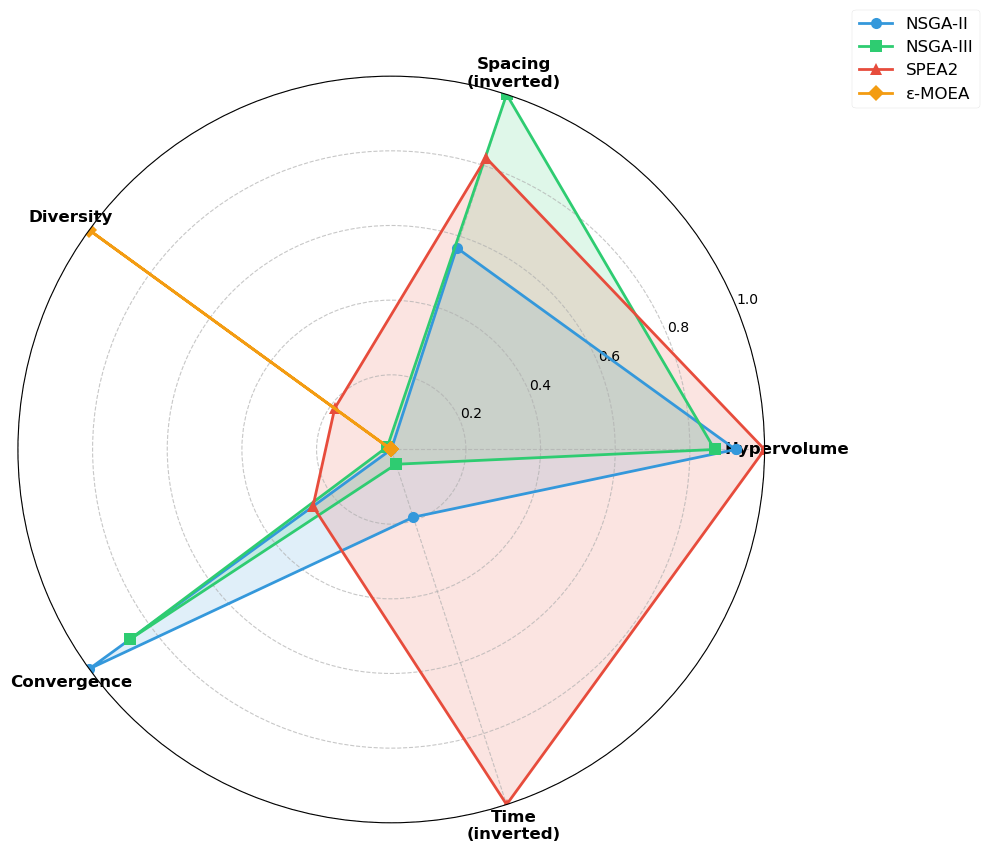

In [6]:
# Normalize data
metrics = ['Hypervolume', 'Spacing\n(inverted)', 'Diversity', 'Convergence', 'Time\n(inverted)']

hypervolume = np.array([np.mean(DATA['HYPERVOLUME'][algo]) for algo in ALGORITHMS])
spacing = np.array([np.mean(DATA['SPACING'][algo]) for algo in ALGORITHMS])
diversity = np.array([np.mean(DATA['DIVERSITY'][algo]) for algo in ALGORITHMS])
convergence = np.array([np.mean(DATA['CONVERGENCE'][algo]) for algo in ALGORITHMS])
time = np.array([np.mean(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])

def normalize(values, invert=False):
    if invert:
        values = 1.0 / (values + 0.001)
    normalized = (values - values.min()) / (values.max() - values.min() + 1e-10)
    return normalized

data_matrix = np.array([
    normalize(hypervolume),
    normalize(spacing, invert=True),  # Lower is better
    normalize(diversity),
    normalize(convergence, invert=True),  # Lower is better
    normalize(time, invert=True)  # Lower is better
]).T

# Radar chart
angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
data_matrix = np.concatenate((data_matrix, data_matrix[:, [0]]), axis=1)
angles += angles[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'D']

for i, (algo, color, marker) in enumerate(zip(ALGORITHMS, colors, markers)):
    ax.plot(angles, data_matrix[i], 'o-', linewidth=2, color=color, 
            label=algo, marker=marker, markersize=8)
    ax.fill(angles, data_matrix[i], alpha=0.15, color=color)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(metrics, size=12, weight='bold')
ax.set_ylim(0, 1)
ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'], size=10)
ax.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)
plt.tight_layout()
plt.savefig(f'../../result/figures/figure1_radar_chart.png', dpi=300, bbox_inches='tight')

## Figure 2: Hypervolume Distribution Box Plots

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data
data_list = [DATA['HYPERVOLUME'][algo] for algo in ALGORITHMS]
positions = np.arange(len(ALGORITHMS))

# Create box plots
bp = ax.boxplot(data_list, positions=positions, widths=0.6,
                patch_artist=True, showmeans=True,
                meanprops=dict(marker='D', markerfacecolor='red', 
                                markeredgecolor='red', markersize=8))

# Color boxes
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

# Add individual points
for i, data in enumerate(data_list):
    y = data
    x = np.random.normal(i, 0.04, size=len(y))
    ax.scatter(x, y, alpha=0.4, s=30, color=colors[i])

# Formatting
ax.set_xticks(positions)
ax.set_xticklabels(ALGORITHMS, fontsize=12, weight='bold')
ax.set_ylabel('Hypervolume', fontsize=12, weight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add overall mean line
overall_mean = np.mean([np.mean(d) for d in data_list])
ax.axhline(overall_mean, color='gray', linestyle='--', alpha=0.5, 
            label=f'Overall Mean: {overall_mean:.3f}')
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig('../../result/figures/figure2_hypervolume_boxplots.png', dpi=300, bbox_inches='tight')

## Figure 3: Execution Time Comparison

In [ ]:
fig, ax = plt.subplots(figsize=(10, 7))

means = np.array([np.mean(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])
stds = np.array([np.std(DATA['EXECUTION_TIME'][algo]) for algo in ALGORITHMS])

x = np.arange(len(ALGORITHMS))
colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c']

bars = ax.barh(x, means, xerr=stds, capsize=5, alpha=0.7,
                color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    ax.text(mean + std + 10, i, f'{mean:.1f}s', 
            va='center', fontsize=11, weight='bold')

# Formatting
ax.set_yticks(x)
ax.set_yticklabels(ALGORITHMS, fontsize=12, weight='bold')
ax.set_xlabel('Execution Time (seconds)', fontsize=12, weight='bold')
ax.grid(axis='x', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('../../result/figures/figure3_execution_time.png', dpi=300, bbox_inches='tight')

## Table 1: Performance Summary Table

In [ ]:
# Prepare data
metrics = ['HYPERVOLUME', 'SPACING', 'DIVERSITY', 'CONVERGENCE', 'EXECUTION_TIME']
metric_labels = ['Hypervolume', 'Spacing', 'Diversity', 'Convergence', 'Time (sec)']

table_data = []
table_data.append(['Metric'] + ALGORITHMS)

for metric, label in zip(metrics, metric_labels):
    row = [label]
    for algo in ALGORITHMS:
        mean = np.mean(DATA[metric][algo])
        std = np.std(DATA[metric][algo])
        if metric == 'EXECUTION_TIME':
            row.append(f'{mean:.1f}±{std:.1f}')
        else:
            row.append(f'{mean:.3f}±{std:.3f}')
    table_data.append(row)

df = pd.DataFrame(table_data[1:], columns=table_data[0])
df = df.set_index('Metric')
df.to_excel('../../result/tables/Table1.xlsx', engine='openpyxl')

## 기타

In [ ]:
'''fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

for algo, color in zip(['NSGA-II', 'NSGA-III', 'SPEA2'], 
                       ['#FF6B6B', '#4ECDC4', '#95E1D3']):
    mask = df['Algorithm'] == algo
    scatter = ax.scatter(
        df.loc[mask, 'Nutrition'],
        df.loc[mask, 'Cost'],
        df.loc[mask, 'Harmony'],
        c=df.loc[mask, 'Diversity'],  # 4번째 목적함수를 색상으로
        s=150,
        alpha=0.7,
        cmap='viridis',
        edgecolors='black',
        linewidth=1,
        label=algo
    )

ax.set_xlabel('Nutritional Adequacy', fontsize=12, fontweight='bold')
ax.set_ylabel('Cost Effectiveness', fontsize=12, fontweight='bold')
ax.set_zlabel('Menu Harmony', fontsize=12, fontweight='bold')
ax.set_title('4D Pareto Front Visualization\n(Color = Dietary Diversity)', 
             fontsize=14, fontweight='bold', pad=20)

# Colorbar for 4th objective
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)
cbar.set_label('Dietary Diversity', fontsize=11, fontweight='bold')

ax.legend(loc='upper left', fontsize=10)
ax.view_init(elev=25, azim=45)

plt.tight_layout()
plt.savefig('../../result/figures/method1_3d_color_mapping.png', dpi=300, bbox_inches='tight')'''

In [ ]:
'''fig, ax = plt.subplots(figsize=(10, 8))

colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']
markers = ['o', 's', '^', 'D']

for i, (algo, color, marker) in enumerate(zip(ALGORITHMS, colors, markers)):
    diversity_runs = DATA['DIVERSITY'][algo]
    convergence_runs = DATA['CONVERGENCE'][algo]
    
    # Scatter points
    ax.scatter(diversity_runs, convergence_runs, s=100, alpha=0.6,
                color=color, marker=marker, edgecolors='black', linewidth=1,
                label=algo)
    
    # Add 95% confidence ellipse
    from matplotlib.patches import Ellipse
    mean_div = np.mean(diversity_runs)
    mean_conv = np.mean(convergence_runs)
    std_div = np.std(diversity_runs)
    std_conv = np.std(convergence_runs)
    
    ellipse = Ellipse((mean_div, mean_conv), width=2*std_div, height=2*std_conv,
                        alpha=0.2, facecolor=color, edgecolor=color, linewidth=2)
    ax.add_patch(ellipse)
    
    # Add mean marker
    ax.scatter(mean_div, mean_conv, s=200, alpha=0.9, color=color,
                marker=marker, edgecolors='black', linewidth=2)

# Formatting
ax.set_xlabel('Diversity (Objective Space Extent)', fontsize=12, weight='bold')
ax.set_ylabel('Convergence (Lower is Better)', fontsize=12, weight='bold')
ax.set_title('Trade-off Between Exploration and Exploitation\n(95% confidence ellipses)', 
            fontsize=13, weight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='upper left')

plt.tight_layout()'''

In [ ]:
'''fig, axes = plt.subplots(3, 2, figsize=(14, 16))
objectives = ['Nutrition', 'Cost', 'Harmony', 'Diversity']
colors_map = {'NSGA-II': '#FF6B6B', 'NSGA-III': '#4ECDC4', 'SPEA2': '#95E1D3'}

pairs = [
    ('Nutrition', 'Cost'),
    ('Nutrition', 'Harmony'),
    ('Nutrition', 'Diversity'),
    ('Cost', 'Harmony'),
    ('Cost', 'Diversity'),
    ('Harmony', 'Diversity')
]

for idx, (obj1, obj2) in enumerate(pairs):
    ax = axes.flat[idx]
    for algo in ['NSGA-II', 'NSGA-III', 'SPEA2']:
        mask = df['Algorithm'] == algo
        ax.scatter(df.loc[mask, obj1], df.loc[mask, obj2], 
                  color=colors_map[algo], label=algo, 
                  s=80, alpha=0.6, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel(obj1, fontsize=11, fontweight='bold')
    ax.set_ylabel(obj2, fontsize=11, fontweight='bold')
    ax.set_title(f'{obj1} vs {obj2}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    if idx == 0:
        ax.legend(fontsize=9)

plt.suptitle('4D Pareto Front: Pairwise Objective Comparisons', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()'''

In [ ]:
'''from pandas.plotting import parallel_coordinates

fig, ax = plt.subplots(figsize=(14, 8))

parallel_coordinates(
    df,
    'Algorithm',
    cols=['Nutrition', 'Cost', 'Harmony', 'Diversity'],
    color=['#FF6B6B', '#4ECDC4', '#95E1D3'],
    alpha=0.3,
    linewidth=1.5,
    ax=ax
)

ax.set_title('4D Pareto Front: Parallel Coordinates', 
             fontsize=16, fontweight='bold', pad=20)
ax.set_ylabel('Normalized Objective Value', fontsize=12, fontweight='bold')
ax.set_ylim([0.5, 1.05])
ax.grid(True, alpha=0.3, axis='y')
ax.legend(loc='lower right', fontsize=11)

plt.tight_layout()'''